# Turbulence numerical explorations
## Lecture 3

Author: Enrico Calzavarini enrico.calzavarini@univ-lille.fr

We look at the velocity specrta , velocity correlations and velocity increments statistics


First we read turbulent flow field data from a **hdf5** file. 

In [2]:
from math import *
import numpy as np
import h5py

fname="../HIT_128/field_10000.h5"
f = h5py.File( fname,'r')

vx=np.array(f['euler']['velocity_x'])
vy=np.array(f['euler']['velocity_y'])
vz=np.array(f['euler']['velocity_z'])

NZ = vx.shape[0]
NY = vx.shape[1]
NX = vx.shape[2]
print(NX,NY,NZ)

128 128 128


This script computes:
- compute the 3D spectra of the velocity field
- save the data on file
- draw a gaph and compare with Komlogorov -5/3 scaling

In [32]:
# defining global types and fields
real_vector_dtype=np.dtype({'names':['x','y','z'], 'formats':[float,float,float] })
complex_vector_dtype=np.dtype({'names':['x','y','z'], 'formats':[complex,complex,complex]})

# define real field
ur = np.zeros((NX,NY,NZ),real_vector_dtype)
ur['x'] = vx
ur['y'] = vy
ur['z'] = vz 


# define field in spectral space
# note that if f(x) is a real function, then its Fourier transform has a symmetry:
# f(k)^* = f(-k) where ^* denotes the complex conjugate of the fourier transoform
# this allows to store the data in nearly half of the space
half_NZ_plus_1 = int(NZ/2+1)
uc = np.zeros((NX,NY,half_NZ_plus_1),complex_vector_dtype)


###################################################
# Fourier  transform
def fftv(ur):
    uc = np.zeros((NX,NY,half_NZ_plus_1),complex_vector_dtype) #this is an internal variable
    norm=1.#/ur['x'].size
    uc['x'] = np.fft.rfftn(ur['x'])*norm
    uc['y'] = np.fft.rfftn(ur['y'])*norm
    uc['z'] = np.fft.rfftn(ur['z'])*norm
    return uc;

###############################################
# Preliminary to spectra , the vector number arrays

kx = np.fft.fftfreq(NX, 1./NX)
ky = np.fft.fftfreq(NY, 1./NY)
#kz = np.linspace(0, NZ/2, NZ/2+1, float)
kz = np.fft.rfftfreq(NZ, 1./NZ)


####################################################
# Compute spectra
def compute_spectra(uc):
    ene=0.0
    spect = np.zeros(half_NZ_plus_1, float)
    kspect = np.zeros(half_NZ_plus_1, float)
    for i in range(0,NX):
        for j in range(0,NY):
            for k in range(0,half_NZ_plus_1):
                kabs=sqrt(kx[i]**2. + ky[j]**2. + kz[k]**2.)
                ik=int(ceil(kabs))
                if (k==0 or k==NZ/2):
                    fac=0.5
                else:
                    fac=1.0                    
                if ik < half_NZ_plus_1:
                    ene = (np.abs(uc['x'][i,j,k]))**2. + (np.abs(uc['y'][i,j,k]))**2. + (np.abs(uc['z'][i,j,k]))**2.
                    spect[ik] += fac*ene;
                    kspect[ik] = kabs  
    return kspect,spect            
##################

# compute spectra
uc = fftv(ur) 
kspect,spect=compute_spectra(uc)

with open('spectra.dat', 'w') as f:
    for i in range(0,half_NZ_plus_1):
        #print >> f, i , spect[i]
        line = str(kspect[i])+" "+str(spect[i])+"\n"
        f.write(line)
f.closed     


True

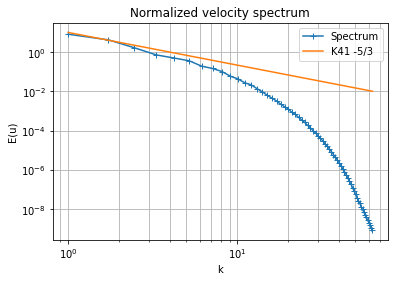

In [31]:
######
# graph
import matplotlib.pyplot as plt
plt.loglog(kspect[1:],spect[1:]/spect[0],"+-",label='Spectrum')
plt.loglog(kspect[1:], 10.*np.power(kspect[1:],-5./3.),label='K41 -5/3' ) 
plt.grid(True, which="both") 
plt.xlabel('k')
plt.ylabel('E(u)')
plt.title("Normalized velocity spectrum")  
plt.legend()
plt.show()

### Compute the velocity correlation function from the spectrum

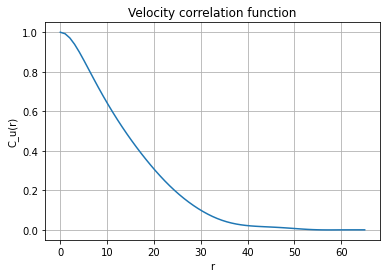

In [29]:
corr = np.fft.irfftn(spect)
x=np.linspace(0,half_NZ_plus_1,half_NZ_plus_1)
corr_norm =  corr[0:half_NZ_plus_1] - corr[half_NZ_plus_1] 
corr_norm /= corr_norm[0]

plt.plot(x,corr_norm)
plt.grid(True, which="both")
plt.xlabel('r')
plt.ylabel('C_u(r)')
plt.title("Velocity correlation function")  
plt.show()

This is equivalent to the computation of the correlation function in real space, but it is much faster as the algorithm is $O(N \log_2N)$ instead of $O(N^2)$.


## Study of the velocity spatial increments
This script computes:
- compute PDF for several velocity increments and make a plot
- compute the scale dependent flatness

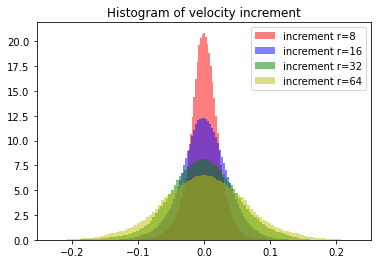

In [33]:
def wrap(x,s):
    return int( (x) - np.floor((x) / s) * s )

def increments(step):
    dv = np.zeros((3,NX,NY,NZ))    
    #here I compute the energy dissipation rate
    for i in range(NX):
        for j in range(NY):
            for k in range(NZ):
                #compute the velocity increment (only along x)
                ip = wrap(i+step,NX)
                dv[0][i][j][k]= (vx[ip][j][k] - vx[i][j][k])
                jp = wrap(j+step,NY)
                dv[1][i][j][k]= (vy[i][jp][k] - vy[i][j][k])
                kp = wrap(k+step,NZ)
                dv[2][i][j][k]= (vz[i][j][kp] - vz[i][j][k])                                
    return dv

step = 8
aux = increments(step)
a = np.reshape(aux, (3*NX*NY*NZ))
step = 16
aux = increments(step)
b = np.reshape(aux, (3*NX*NY*NZ))
step = 32
aux = increments(step)
c = np.reshape(aux, (3*NX*NY*NZ))
step = 64
aux = increments(step)
d = np.reshape(aux, (3*NX*NY*NZ))


# Check the shape of the distribution of velocity
# make a single array
#import matplotlib.pyplot as plt
bins = 100
plt.hist(a, bins, density=True, facecolor='r', alpha=0.5,label='increment r=8' )
plt.hist(b, bins, density=True, facecolor='b', alpha=0.5,label='increment r=16' )
plt.hist(c, bins, density=True, facecolor='g', alpha=0.5,label='increment r=32')
plt.hist(d, bins, density=True, facecolor='y', alpha=0.5,label='increment r=64')
plt.title("Histogram of velocity increment")
plt.legend(loc='upper right')  
plt.show()

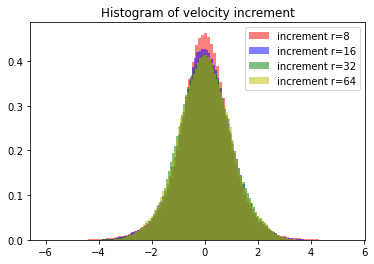

In [34]:
#normalized variable  
step = 8
aux = increments(step) 
aux /= np.std(aux)
a = np.reshape(aux, (3*NX*NY*NZ))
step = 16
aux = increments(step)
aux /= np.std(aux)
b = np.reshape(aux, (3*NX*NY*NZ))
step = 32
aux = increments(step)
aux /= np.std(aux)
c = np.reshape(aux, (3*NX*NY*NZ))
step = 64
aux = increments(step)
aux /= np.std(aux)
d = np.reshape(aux, (3*NX*NY*NZ))


# Check the shape of the distribution of velocity
# make a single array
#import matplotlib.pyplot as plt
bins = 100
plt.hist(a, bins, density=True, facecolor='r', alpha=0.5,label='increment r=8' )
plt.hist(b, bins, density=True, facecolor='b', alpha=0.5,label='increment r=16' )
plt.hist(c, bins, density=True, facecolor='g', alpha=0.5,label='increment r=32')
plt.hist(d, bins, density=True, facecolor='y', alpha=0.5,label='increment r=64')
plt.title("Histogram of velocity increment")
plt.legend(loc='upper right')  
plt.show()

## Flatness (or Kurtosis) of velocity increments

1 6.744504836462194
2 6.4507840519382595
3 6.049947457439208
4 5.620923696294621
5 5.216476400114856
6 4.860897480833148
7 4.5596161819268275
8 4.309122531639626
9 4.1031657391178475
10 3.935398289619483
11 3.799965638543518
12 3.6914669795107575
13 3.60497630028275
14 3.5361666236990748
15 3.481402764911119
16 3.437735221024251
17 3.4027969154078845
18 3.3746536770126503
19 3.3516789552178206
20 3.332491626129236
21 3.3159479646298156
22 3.301154670907536
23 3.287472174913115
24 3.2744941469417927
25 3.2620047136297714
26 3.2499197970369855
27 3.23822181364586
28 3.2269055788196965
29 3.2159559835994886
30 3.205361808553406
31 3.1951447679698286
32 3.1853726341562485
33 3.1761404975293104
34 3.167530090410311
35 3.1595701190232086
36 3.152214657369168
37 3.145345243892266
38 3.1387943015719695
39 3.1323827534458504
40 3.1259630647611467
41 3.119456804406242
42 3.112874918852798
43 3.1063159400354765
44 3.0999470081115015
45 3.093975190260478
46 3.0886142461263395
47 3.08405190652393
4

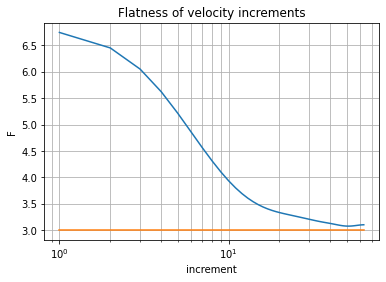

In [7]:
steps=[]
flatness=[]
for i in range(1,64,1):
    step=i
    aux = increments(step)
    m4 = np.mean(aux*aux*aux*aux)
    m2 = np.mean(aux*aux)
    f = (m4/(m2*m2))
    flatness.append(f)
    steps.append(step)
    print(i,f)

# write on file
with open('flatness.dat', 'w') as f:
    for i in range(len(flatness)):
            line = str(steps[i])+" "+str(flatness[i])+"\n"
            f.write(line)
f.closed                

# graph
#eta = 1.5 #Kolmogorov scale
plt.semilogx(steps, flatness,label='Flatness' )
plt.semilogx(steps, 3*np.ones(len(steps)),label='Gaussian' ) 
plt.grid(True, which="both") 
plt.xlabel('increment')
plt.ylabel('F')
plt.title("Flatness of velocity increments")  
plt.show()